# 4. Multi-Input & Multi-Output Architectures

Build multi-input and multi-output models, demonstrating how they can handle tasks requiring more than one input or generating multiple outputs. You will explore how to design and train these models using PyTorch and delve into the crucial topic of loss weighting in multi-output models. This involves understanding how to balance the importance of different tasks when training a model to perform multiple tasks simultaneously.

## Prepare environment

In [1]:
# Importing libraries
import expectexception
import matplotlib.pyplot as plt
import numpy as np
import os
import re

import torch
import torch.nn as nn
import torch.optim as optim

from environment import prepare_environment
from PIL import Image
from typing import List, Tuple
from sklearn.preprocessing import LabelBinarizer
from pprint import pprint

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchmetrics import Accuracy

In [2]:
# Global variables
SEED = 42

DATASET_OMNIGLOT_TRAIN = "data-sources/omniglot/omniglot_train/"
DATASET_OMNIGLOT_TEST = "data-sources/omniglot/omniglot_test/"

In [3]:
# Check if your GPU driver and CUDA is enabled and accessible by PyTorch
print(torch.__version__)
print('Cuda is available?', torch.cuda.is_available())

2.4.1+cu124
Cuda is available? True


In [4]:
# Global configuration
prepare_environment()

torch.set_printoptions(precision=10)

# Reproducibility
np.random.seed(SEED)
_ = torch.manual_seed(SEED)

## **4.1 MULTI-INPUT MODELS**

### Omniglot - Reviewing the data

In [5]:
print('TRAIN DATASET:')
total_img = 0
total_chr = 0
for directory in os.listdir(DATASET_OMNIGLOT_TRAIN):
    char_files = [(len(d), len(f)) 
                  for _, d, f in os.walk(DATASET_OMNIGLOT_TRAIN + directory)]
    num_chars, num_files = map(sum, zip(*char_files))
    print(f'- {directory:<42} >> chars: {num_chars}, images: {num_files}')
    total_img += num_files
    total_chr += num_chars
print(f'Total images: {total_img} ({total_chr} characters)')

TRAIN DATASET:
- Alphabet_of_the_Magi                       >> chars: 20, images: 301
- Anglo-Saxon_Futhorc                        >> chars: 29, images: 438
- Arcadian                                   >> chars: 26, images: 398
- Armenian                                   >> chars: 41, images: 620
- Asomtavruli_(Georgian)                     >> chars: 40, images: 575
- Balinese                                   >> chars: 24, images: 369
- Bengali                                    >> chars: 46, images: 680
- Blackfoot_(Canadian_Aboriginal_Syllabics)  >> chars: 14, images: 205
- Braille                                    >> chars: 26, images: 397
- Burmese_(Myanmar)                          >> chars: 34, images: 511
- Cyrillic                                   >> chars: 33, images: 482
- Early_Aramaic                              >> chars: 22, images: 338
- Futurama                                   >> chars: 26, images: 400
- Grantha                                    >> chars: 43, ima

In [6]:
print('TEST DATASET:')
total_img = 0
total_chr = 0
for directory in os.listdir(DATASET_OMNIGLOT_TEST):
    char_files = [(len(d), len(f)) 
                  for _, d, f in os.walk(DATASET_OMNIGLOT_TEST + directory)]
    num_chars, num_files = map(sum, zip(*char_files))
    print(f'- {directory:<42} >> chars: {num_chars}, images: {num_files}')
    total_img += num_files
    total_chr += num_chars
print(f'Total images: {total_img} ({total_chr} characters)')

TEST DATASET:
- Alphabet_of_the_Magi                       >> chars: 20, images: 244
- Anglo-Saxon_Futhorc                        >> chars: 29, images: 351
- Arcadian                                   >> chars: 26, images: 328
- Armenian                                   >> chars: 41, images: 537
- Asomtavruli_(Georgian)                     >> chars: 40, images: 510
- Balinese                                   >> chars: 24, images: 302
- Bengali                                    >> chars: 46, images: 594
- Blackfoot_(Canadian_Aboriginal_Syllabics)  >> chars: 14, images: 175
- Braille                                    >> chars: 26, images: 302
- Burmese_(Myanmar)                          >> chars: 34, images: 429
- Cyrillic                                   >> chars: 33, images: 410
- Early_Aramaic                              >> chars: 22, images: 282
- Futurama                                   >> chars: 26, images: 321
- Grantha                                    >> chars: 43, imag

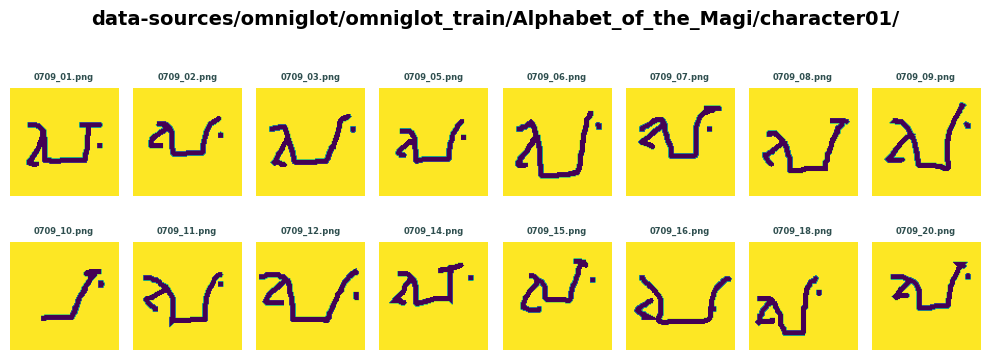

In [7]:
image_dir = DATASET_OMNIGLOT_TRAIN + os.listdir(DATASET_OMNIGLOT_TRAIN)[0]
image_dir = image_dir + '/' + os.listdir(image_dir)[0] + '/'
images = os.listdir(image_dir)

fig, axes =  plt.subplots(2, int(len(images)/2), figsize=(10, 4))
fig.suptitle(image_dir)
axes = axes.flatten()
for i, ax in enumerate(axes):
    image = plt.imread(f"{image_dir}{images[i]}")
    ax.imshow(image)
    ax.set_title(images[i], fontsize=6)
    ax.axis('off')
plt.tight_layout()
plt.show()

### Two-input Dataset

In [8]:
class OmniglotDataset(Dataset):
    """Extended DatasetClass to generate a 2-input Dataset."""
    def __init__(self, 
                 transform: transforms.transforms.Compose, 
                 samples: List[Tuple[str, np.ndarray, int]]) -> None:
        self.transform = transform
        self.samples = samples
    
    def __len__(self) -> int:
        return len(self.samples)
        
    def __getitem__(self, idx) -> Tuple[Image.Image, np.ndarray, int]:
        img_path, alphabet, label = self.samples[idx]
        img = Image.open(img_path).convert('L')  # L >> Grayscale
        img = self.transform(img)
        return img, alphabet, label

In [9]:
def get_samples(root_dir: str) -> List[Tuple[str, np.ndarray, int]]:
    """Get samples to use in the Two-Input-Dataset."""
    samples = []
    alphabet_dict = {}
    char_pos = -1
    prev_alphabet = ''
    for path, root, files in os.walk(root_dir):
        if not alphabet_dict:
            encoder = LabelBinarizer()
            alphabet_1hot = encoder.fit_transform(root)
            alphabet_dict = {root[i]: alphabet_1hot[i] for i in range(len(root))}
        if files:
            if files[0][-3:] == 'png':
                path_items = path.replace('\\', '/').split('/')
                alphabet_name = path_items[-2]
                if alphabet_name != prev_alphabet:
                    if prev_alphabet != '':
                        char_pos = char_num
                    prev_alphabet = alphabet_name
                alphabet = alphabet_dict[alphabet_name]
                char_num = int(re.search(r'\d{0,3}$', path_items[-1]).group()) + char_pos
                samples.extend([(os.path.join(path, file), alphabet, char_num)
                                for file in files])
    return samples

samples = get_samples(DATASET_OMNIGLOT_TRAIN)
print(len(samples))
pprint(samples[-3:])

14400
[('data-sources/omniglot/omniglot_train/Tifinagh\\character55\\0964_17.png',
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1]),
  963),
 ('data-sources/omniglot/omniglot_train/Tifinagh\\character55\\0964_18.png',
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1]),
  963),
 ('data-sources/omniglot/omniglot_train/Tifinagh\\character55\\0964_20.png',
  array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1]),
  963)]


In [10]:
# Train transformation
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((64, 64)),
                                      ])

# Create the train dataset
dataset_train = OmniglotDataset(transform=train_transforms, samples=samples)
print('Num Samples:', len(dataset_train))

Num Samples: 14400


Data point: torch.Size([1, 64, 64])
Image reshaped torch.Size([64, 64, 1])


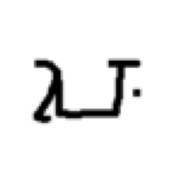

In [11]:
# reviewing the dataset
image, alphabet, label = dataset_train[0]
print("Data point:", image.shape)

image = image.permute(1, 2, 0)
print("Image reshaped", image.shape)

fig = plt.figure(figsize=(2, 2))
plt.imshow(image, cmap='gray')
plt.axis('off')
plt.show()

### Tensor concatenation

In [12]:
x = torch.tensor([[1, 2, 3],])
y = torch.tensor([[4, 5, 6],])

torch.cat((x, y), dim=0)

tensor([[1, 2, 3],
        [4, 5, 6]])

In [13]:
torch.cat((x, y), dim=1)

tensor([[1, 2, 3, 4, 5, 6]])

### Model TwoInputNetModel

In [14]:
class TwoInputNetModel(nn.Module):
    """Two-Input Architecture Model to predict a character and 
    the alphabet it belongs to.
    """
    def __init__(self):
        super().__init__()
        self.image_layer = nn.Sequential(         # Input img 1X64x64 (channel, w, h)
            nn.Conv2d(1, 16, 
                      kernel_size=3, padding=1),  # In-channel=1, Out-channel=16 → 16x64x64
            nn.MaxPool2d(kernel_size=2),          # Divide image size by 2 → 16x32x32
            nn.ELU(),                             # No Changes → 16x32x32
            nn.Flatten(),                         # Flatten → 16x32x32
            nn.Linear(16*32*32, 128),             # No Changes → 16x32x32
        )
        self.alphabet_layer = nn.Sequential(
            nn.Linear(30, 8),
            nn.ELU()
        )
        self.classifier = nn.Sequential(
            nn.Linear(128+8, 964),
        )

    def forward(self, x_image:torch.Tensor, x_alphabet:torch.Tensor):
        x_image = x_image.float()
        x_alphabet = x_alphabet.float()
        x_image = self.image_layer(x_image)
        x_alphabet = self.alphabet_layer(x_alphabet)
        x = torch.cat((x_image, x_alphabet), dim=1)
        return self.classifier(x)

### Training loop

In [15]:
# Create a DataLoader based on dataset_train
dataloader_train = DataLoader(dataset_train, batch_size=20, shuffle=True)

In [16]:
# Build the model
model_s = TwoInputNetModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_s.parameters(), lr=0.001)  # weight_decay=1e-4

In [17]:
losses = []
epochs = 10

model_s.train()
for epoch in range(epochs):
    running_loss = 0.0
    
    for img, alpha, labels in dataloader_train:
        optimizer.zero_grad()                       # zero the parameter gradients
        outputs = model_s(img, alpha)               # Run a forward pass
        loss = criterion(outputs, labels)           # Compute loss
        loss.backward()                             # Backward pass
        optimizer.step()                            # Optimization
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    losses.append(epoch_loss)                       # Record the loss per epoch
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

Epoch 1, Loss: 6.317558
Epoch 2, Loss: 3.107628
Epoch 3, Loss: 1.684771
Epoch 4, Loss: 1.017210
Epoch 5, Loss: 0.590794
Epoch 6, Loss: 0.348646
Epoch 7, Loss: 0.213099
Epoch 8, Loss: 0.170868
Epoch 9, Loss: 0.176374
Epoch 10, Loss: 0.157896


In [18]:
print(f"""
labels: {labels.shape}
{labels}

outputs: {outputs.shape}
{outputs}
""")


labels: torch.Size([20])
tensor([ 79, 135, 704, 504, 694, 143, 932, 111, 412, 386, 620, 605, 300, 841,
        245, 868, 645, 642, 412, 404])

outputs: torch.Size([20, 964])
tensor([[  4.6852645874,  -3.5561432838, -18.2632179260,  ...,
          -1.4617226124, -12.2764701843,   0.0449283905],
        [ 15.0398254395,   0.6418653727,  -6.6526641846,  ...,
           5.1501126289,  -8.1191196442,  12.3014316559],
        [-12.0017471313, -10.3067226410,  -7.4454588890,  ...,
           5.2670464516,  -7.7194418907, -12.2887754440],
        ...,
        [ -2.8296546936, -15.1807613373, -13.9458980560,  ...,
         -20.8065414429, -10.1518735886,  -4.0766553879],
        [  3.9476552010, -12.9556465149, -13.8123302460,  ...,
         -14.5375967026,  -8.9736127853,   0.2092254460],
        [ -4.0170798302,  -5.8028154373,  -5.7182531357,  ...,
          -5.8551440239, -12.7274618149,   5.7907824516]],
       grad_fn=<AddmmBackward0>)



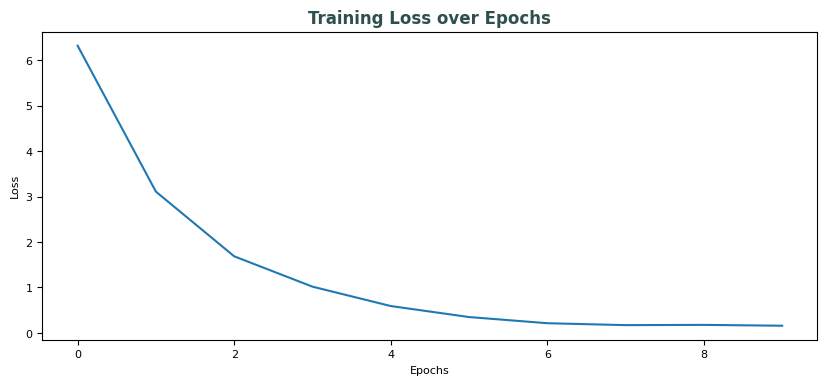

In [19]:
# Visualizing the loss in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Ex.1 - Two-input dataset

Building a multi-input model starts with crafting a custom dataset that can supply all the inputs to the model. In this exercise, you will build the Omniglot dataset that serves triplets consisting of:

- The image of a character to be classified,
- The one-hot encoded alphabet vector of length 30, with zeros everywhere but for a single one denoting the ID of the alphabet the character comes from,
- The target label, an integer between 0 and 963.

You are provided with train_samples, a list of 3-tuples comprising an image's file path, its alphabet vector, and the target label. Also, the following imports have already been done for you, so let's get to it!
```
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
```

**Instructions**

1. Assign `transform` and `samples` to class attributes with the same names.
2. Implement the `.__len()__` method such that it return the number of samples stored in the class' `samples` attribute.
3. Unpack the sample at index `idx` assigning its contents to `img_path`, `alphabet`, and `label`.
4. Transform the loaded image with `self.transform()` and assign it to `img_transformed`.

**Code result**

-----------------------
```
class OmniglotDataset(Dataset):
    def __init__(self, transform, samples):
		# Assign transform and samples to class attributes
        self.transform = transform
        self.samples = samples
                    
    def __len__(self):
		# Return number of samples
        return len(self.samples)

    def __getitem__(self, idx):
      	# Unpack the sample at index idx
        img_path, alphabet, label = self.samples[idx]
        img = Image.open(img_path).convert('L')
        # Transform the image 
        img_transformed = self.transform(img)
        return img_transformed, alphabet, label
```

-----------------------

5. Nice done! With your implementation of `OmniglotDataset` ready, you can actually create the dataset and DataLoader, just like you did it before.
```
dataset_train = OmniglotDataset(
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((64, 64)),
    ]),
    samples=samples,
)

dataloader_train = DataLoader(
    dataset_train, shuffle=True, batch_size=3,
)
```

What will `dataloader_train` produce? To answer, feel free to execute the code above and peek at the first batch of data returned by the DataLoader!

**Possible answers**
- [ ] (images, labels)
- [ ] (alphabet vectors, images, labels)
- [ ] (labels, images, alphabet_vectors)
- [X] (images, alphabet vectors, labels)

### Ex.2 - Two-input model

With the data ready, it's time to build the two-input model architecture! To do so, you will set up a model class with the following methods:

- `.__init__()`, in which you will define sub-networks by grouping layers; this is where you define the two layers for processing the two inputs, and the classifier that returns a classification score for each class.
- `forward()`, in which you will pass both inputs through corresponding pre-defined sub-networks, concatenate the outputs, and pass them to the classifier.

`torch.nn` is already imported for you as nn. Let's do it!

**Instructions**

1. Define image, alphabet and classifier sub-networks as sequential models, assigning them to self.image_layer, self.alphabet_layer and self.classifier, respectively.
2. Pass the image and alphabet through the appropriate model layers.
3. Concatenate the outputs from image and alphabet layers and assign the result to `x`.

**Code result**

---------------------------
```
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define sub-networks as sequential models
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        self.alphabet_layer = nn.Sequential(
            nn.Linear(30, 8),
            nn.ELU(), 
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 + 8, 964), 
        )
        
    def forward(self, x_image, x_alphabet):
		# Pass the x_image and x_alphabet through appropriate layers
        x_image = self.image_layer(x_image)
        x_alphabet = self.alphabet_layer(x_alphabet)
        # Concatenate x_image and x_alphabet
        x = torch.cat((x_image, x_alphabet), dim=1)
        return self.classifier(x)
```

---------------------------

## **4.2 MULTI-OUTPUT MODELS**

### Two-Output Dataset

We are going to use our `OmniglotDataset` dataset but we are going to create a different `get_sample` function.

In [20]:
def get_samples2(root_dir: str) -> List[Tuple[str, np.ndarray, int]]:
    """Get samples to use in the Two-Input-Dataset."""
    samples = []
    alphabet_dict = []
    char_pos = -1
    prev_alphabet = ''
    for path, root, files in os.walk(root_dir):
        if not alphabet_dict:
            alphabet_dict = root
        if files:
            if files[0][-3:] == 'png':
                path_items = path.replace('\\', '/').split('/')
                alphabet_name = path_items[-2]
                if alphabet_name != prev_alphabet:
                    if prev_alphabet != '':
                        char_pos = char_num
                    prev_alphabet = alphabet_name
                alphabet = alphabet_dict.index(alphabet_name)
                char_num = int(re.search(r'\d{0,3}$', path_items[-1]).group()) + char_pos
                samples.extend([(os.path.join(path, file), alphabet, char_num)
                                for file in files])
    return samples

In [21]:
samples2 = get_samples2(DATASET_OMNIGLOT_TRAIN)
print(len(samples2))
pprint(samples2[-3:])

14400
[('data-sources/omniglot/omniglot_train/Tifinagh\\character55\\0964_17.png',
  29,
  963),
 ('data-sources/omniglot/omniglot_train/Tifinagh\\character55\\0964_18.png',
  29,
  963),
 ('data-sources/omniglot/omniglot_train/Tifinagh\\character55\\0964_20.png',
  29,
  963)]


### Model TwoOutputNetModel

In [22]:
class TwoOutputNetModel(nn.Module):
    """Two-Output Architecture Model to predict the character and 
    the alphabet it belongs to.
    """
    def __init__(self):
        super().__init__()
        self.image_layer = nn.Sequential(         # Input img 1X64x64 (channel, w, h)
            nn.Conv2d(1, 16, 
                      kernel_size=3, padding=1),  # In-channel=1, Out-channel=16 → 16x64x64
            nn.MaxPool2d(kernel_size=2),          # Divide image size by 2 → 16x32x32
            nn.ELU(),                             # No Changes → 16x32x32
            nn.Flatten(),                         # Flatten → 16x32x32
            nn.Linear(16*32*32, 128),             # No Changes → 16x32x32
        )
        self.classifier_alpha = nn.Linear(128, 30)
        self.classifier_char = nn.Linear(128, 964)

    def forward(self, x_image:torch.Tensor):
        x_image = x_image.float()
        x_image = self.image_layer(x_image)
        output_alpha = self.classifier_alpha(x_image)
        output_char = self.classifier_char(x_image)
        return output_alpha, output_char

### Training loop

In [23]:
# Train transformation
train_transforms = transforms.Compose([transforms.ToTensor(),
                                       transforms.Resize((64, 64)),
                                      ])

# Create the train dataset
dataset_train2 = OmniglotDataset(transform=train_transforms, samples=samples2)
print('Num Samples:', len(dataset_train2))

Num Samples: 14400


In [24]:
# Create a DataLoader based on dataset_train
dataloader_train2 = DataLoader(dataset_train2, batch_size=20, shuffle=True)

In [25]:
# Build the model
model_s2 = TwoOutputNetModel()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_s2.parameters(), lr=0.001)  # weight_decay=1e-4

In [26]:
losses = []
epochs = 10

model_s2.train()
for epoch in range(epochs):
    running_loss = 0.0
    
    for img, label_alpha, label_char in dataloader_train2:
        optimizer.zero_grad()                       # zero the parameter gradients
        output_alpha, output_char = model_s2(img)             # Run a forward pass
        loss_alpha = criterion(output_alpha, label_alpha)           # Compute loss
        loss_char = criterion(output_char, label_char)              # Compute loss
        loss = loss_alpha + loss_char
        loss.backward()                             # Backward pass
        optimizer.step()                            # Optimization
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader_train)
    losses.append(epoch_loss)                       # Record the loss per epoch
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.6f}")

Epoch 1, Loss: 8.742460
Epoch 2, Loss: 5.832837
Epoch 3, Loss: 4.505525
Epoch 4, Loss: 3.528479
Epoch 5, Loss: 2.776354
Epoch 6, Loss: 2.250045
Epoch 7, Loss: 1.894862
Epoch 8, Loss: 1.648410
Epoch 9, Loss: 1.489207
Epoch 10, Loss: 1.343160


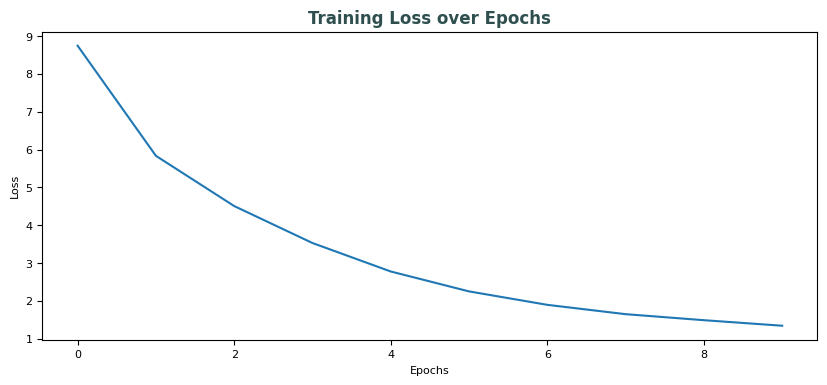

In [27]:
# Visualizing the loss in training set
fig = plt.figure(figsize=(10, 4))
plt.plot(range(epochs), losses)
plt.title("Training Loss over Epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

### Ex.3 - Two-output Dataset and DataLoader

In this and the following exercises, you will build a two-output model to predict both the character and the alphabet it comes from based on the character's image. As always, you will start with getting the data ready.

The `OmniglotDataset` class you have created before is available for you to use along with updated samples. Let's use it to build the Dataset and the DataLoader.

The following imports have already been done for you:
```
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
```

**Instructions**

1. Print the element of `samples2` at index `100` and examine its structure.
2. Use your `OmniglotDataset` to create `dataset_train`, passing the two image transforms you have used before: parse the image to a tensor and resize it to size `(64, 64)`.
3. Create `dataloader_train` from `dataset_train`; `shuffle` the training images and set batch size to `32`.

**Code result:**

-----------------------------
```

# Create dataset_train
dataset_train = OmniglotDataset(
    transform=transforms.Compose([
        transforms.ToTensor(),
      	transforms.Resize((64, 64)),
    ]),
    samples=samples,
)

# Create dataloader_train
dataloader_train = DataLoader(
    dataset_train, batch_size=32, shuffle=True,
)
```

-----------------------------

In [28]:
# Print the sample at index 100
pprint(samples2[100])

('data-sources/omniglot/omniglot_train/Alphabet_of_the_Magi\\character07\\0715_19.png',
 0,
 6)


### Ex.4 - Two-output model architecture

In this exercise, you will construct a multi-output neural network architecture capable of predicting the character and the alphabet.

Recall the general structure: in the `.__init__()` method, you define layers to be used in the forward pass later. In the `forward()` method, you will first pass the input image through a couple of layers to obtain its embedding, which in turn is fed into two separate classifier layers, one for each output.

`torch.nn` is already imported under its usual alias, so let's build a model!

**Instructions**

1. Define `self.classifier_alpha` and `self.classifier_char` as linear layers with input shapes matching the output of `image_layer`, and output shapes corresponding to the number of alphabets (`30`) and the number of characters (`964`), respectively.
2. Pass the image embedding `x_image` separately through each of the classifiers, assigning the results to `output_alpha` and `output_char`, respectively, and return them in this order.

**Code result:**

-----------------------------------
```
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.image_layer = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ELU(),
            nn.Flatten(),
            nn.Linear(16*32*32, 128)
        )
        # Define the two classifier layers
        self.classifier_alpha = nn.Linear(128, 30)
        self.classifier_char = nn.Linear(128, 964)
        
    def forward(self, x):
        x_image = self.image_layer(x)
        # Pass x_image through the classifiers and return both results
        output_alpha = self.classifier_alpha(x_image)
        output_char = self.classifier_char(x_image)
        return output_alpha, output_char
```

--------------------------

### Ex.5 - Training multi-output models

When training models with multiple outputs, it is crucial to ensure that the loss function is defined correctly.

In this case, the model produces two outputs: predictions for the alphabet and the character. For each of these, there are corresponding ground truth labels, which will allow you to calculate two separate losses: one incurred from incorrect alphabet classifications, and the other from incorrect character classification. Since in both cases you are dealing with a multi-label classification task, the Cross-Entropy loss can be applied each time.

Gradient descent can optimize only one loss function, however. You will thus define the total loss as the sum of alphabet and character losses.

**Instructions**

1. Calculate the alphabet classification loss and assign it to `loss_alpha`.
2. Calculate the character classification loss and assign it to `loss_char`.
3. Compute the total loss as the sum of the two partial losses and assign it to `loss`.

**Code result:**

------------------------------------------
```
net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.05)

for epoch in range(1):
    for images, labels_alpha, labels_char in dataloader_train:
        optimizer.zero_grad()
        outputs_alpha, outputs_char = net(images)
        # Compute alphabet classification loss
        loss_alpha = criterion(outputs_alpha, labels_alpha)
        # Compute character classification loss
        loss_char = criterion(outputs_char, labels_char)
        # Compute total loss
        loss = loss_alpha + loss_char
        loss.backward()
        optimizer.step()
```

------------------------------------------

## 4.3 Evaluation of multi-output models and loss weighting

### Model evaluation

In [29]:
# Get samples
samples_test2 = get_samples2(DATASET_OMNIGLOT_TEST)

# Create the test dataset
dataset_test2 = OmniglotDataset(transform=train_transforms, samples=samples_test2)
print('Num Samples:', len(dataset_test2))

# Create a DataLoader based on dataset_test
dataloader_test2 = DataLoader(dataset_test2, batch_size=20, shuffle=True)

Num Samples: 12149


In [30]:
acc_alpha = Accuracy(task="multiclass", num_classes=30)
acc_char = Accuracy(task="multiclass", num_classes=964)

model_s2.eval()
with torch.no_grad():
    for images, labels_alpha, labels_char in dataloader_test2:
        out_alpha, out_char = model_s2(images)
        _, pred_alpha = torch.max(out_alpha, 1)
        _, pred_char = torch.max(out_char, 1)
        acc_alpha(pred_alpha, labels_alpha)
        acc_char(pred_char, labels_char)

print(f"Alphabet: {acc_alpha.compute()}")
print(f"Character: {acc_char.compute()}")

Alphabet: 0.5738744139671326
Character: 0.7181661128997803


### Multi-output training loop revisited

#### Both outputs tasks deemed equally important

In [31]:
loss = loss_alpha + loss_char
loss

tensor(1.9012991190, grad_fn=<AddBackward0>)

#### Varying task importance - Scale more important loss by a factor of 2

In [32]:
loss = loss_alpha + loss_char * 2
loss

tensor(2.0451240540, grad_fn=<AddBackward0>)

#### Varying task importance - Assign weights that sum to 1

In [33]:
loss = 0.33 * loss_alpha + 0.67 * loss_char
loss

tensor(0.6763291955, grad_fn=<AddBackward0>)

### **Warning**: losses on different scales

- Losses must be on the same scale before they are weighted and added
- Example tasks:
    - Predict house price -> MSE loss
    - Predict quality: low, medium, high -> CrossEntropy loss
- CrossEntropy is typically in the single-digits
- MSE loss can reach tens of thousands
- Model would ignore quality assessment task
- Solution: Normalize both losses before weighting and adding

In [34]:
# # Implementation code
# loss_price = loss_price / torch.max(loss_price)
# loss_quality = loss_quality / torch.max(loss_quality)
# loss = 0.7 * loss_price + 0.3 * loss_quality

### Ex.6 - Multi-output model evaluation
In this exercise, you will practice model evaluation for multi-output models. Your task is to write a function called `evaluate_model()` that takes an alphabet-and-character-predicting model as input, runs the evaluation loop, and prints the model's accuracy in the two tasks.

You can assume that the function will have access to `dataloader_test`. The following imports have already been run for you:
```
import torch
from torchmetrics import Accuracy
```

Once you have implemented `evaluate_model()`, you will use it in the following exercise!

**Instructions**
1. Define `acc_alpha` and `acc_char` as multi-class `Accuracy()` metrics for the two outputs, `alphabets` and `characters`, with the appropriate number of classes each (there are `30` alphabets and `964` characters in the dataset).
2. Define the evaluation loop by iterating over test images, `labels_alpha`, and `labels_char`.
3. Inside the for-loop, obtain model results for the test data batch and assign them to `outputs_alpha`, `outputs_char`.
4. Update the two accuracy metrics with the current batch's data.

In [35]:
def evaluate_model(model):
    # Define accuracy metrics
    acc_alpha = Accuracy(task="multiclass", num_classes=30)
    acc_char = Accuracy(task="multiclass", num_classes=964)

    model.eval()
    with torch.no_grad():
        for images, labels_alpha, labels_char in dataloader_test2:
            # Obtain model outputs
            outputs_alpha, outputs_char = model_s2(images)
            _, pred_alpha = torch.max(outputs_alpha, 1)
            _, pred_char = torch.max(outputs_char, 1)
			# Update both accuracy metrics
            acc_alpha(pred_alpha, labels_alpha)
            acc_char(pred_char, labels_char)
    
    print(f"Alphabet: {acc_alpha.compute()}")
    print(f"Character: {acc_char.compute()}")

### Ex.7 - Loss weighting

Three versions of the two-output model for alphabet and character prediction that you built before have been trained: `model_a`, `model_b`, and `model_c`. For all three, the loss was defined as follows:
```
loss_alpha = criterion(outputs_alpha, labels_alpha)
loss_char = criterion(outputs_char, labels_char)
loss = ((1 - char_weight) * loss_alpha) + (char_weight * loss_char)
```
However, each of the three models was trained with a different char_weight: 
- `0.1`,
- `0.5`, or
- `0.9`.

**Instructions**
1. Use the function you have defined in the previous, `evaluate_model()`, to check the accuracy of each model. Which `char_weight` was used to train which model?

**Possible answers:**
- [ ] model_a: 0.1, model_b: 0.5, model_c: 0.9
- [ ] model_a: 0.1, model_b: 0.9, model_c: 0.5
- [X] model_a: 0.5, model_b: 0.1, model_c: 0.9
- [ ] model_a: 0.9, model_b: 0.1, model_c: 0.5
- [ ] model_a: 0.9, model_b: 0.5, model_c: 0.1

```
model_a == model_b == model_c
Net(
  (image_layer): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ELU(alpha=1.0)
    (3): Flatten(start_dim=1, end_dim=-1)
    (4): Linear(in_features=16384, out_features=128, bias=True)
  )
  (classifier_alpha): Linear(in_features=128, out_features=30, bias=True)
  (classifier_char): Linear(in_features=128, out_features=964, bias=True)
)
```

```
In: evaluate_model(model_a)
Alphabet: 0.2808536887168884
Character: 0.1869264841079712

In: evaluate_model(model_b)
Alphabet: 0.35044848918914795
Character: 0.01783689111471176

In: evaluate_model(model_c)
Alphabet: 0.30363956093788147
Character: 0.23837509751319885
```

Well done, that was a tricky one! Notice how the model with 90% of its focus on alphabet recognition (`char_weight=0.1`) does very poorly on the character task. As we increase `char_weight` to `0.5`, the alphabet accuracy drops slightly due to the increased focus on characters, but when it reaches `char_weight=0.9`, the alphabet accuracy increases slightly with the character accuracy, highlighting the synergy between the tasks.

------------------------